### Calculate othormetric height using: 
(1) geoid height;    
(2) corrected geoid height (through using spatial variation of ellipsoidal height).   


In [5]:
import numpy as np
import xarray as xr
from glob import glob
import geopandas as gpd
import matplotlib.pyplot as plt
from utils.functions import sample_from_raster 


In [6]:
path_lake_vec = 'data/dianchi-lake/hydrolake_dianchi_edit.gpkg'
path_geoid_cor = 'data/dianchi-lake/swot-pixc/raster_height_spavar.nc'
dir_pixc = 'data/dianchi-lake/swot-pixc'
paths_pixc_filtered = sorted(glob(dir_pixc + '/*masked_filtered.nc'))  # Get the first .nc file in the directory
paths_pixc_filtered[0]


'data/dianchi-lake/swot-pixc/SWOT_L2_HR_PIXC_009_049_198L_20240105T211648_20240105T211659_PIC0_01_masked_filtered.nc'

In [7]:
## 1. read vector file of the lake.
lake_gdf = gpd.read_file(path_lake_vec)
## 2. read corrected geoid data.
raster_height_spavar = xr.open_dataset(path_geoid_cor)
raster_height_spavar

<xarray.Dataset> Size: 24kB
Dimensions:             (y: 70, x: 42)
Coordinates:
  * x                   (x) float64 336B 102.6 102.6 102.6 ... 102.8 102.8 102.8
  * y                   (y) float64 560B 24.97 24.97 24.96 ... 24.67 24.66 24.66
Data variables:
    ht_spavar_smoothed  (y, x) float64 24kB ...

In [8]:
for path_pixc_filtered in paths_pixc_filtered:
    pixc_filtered = xr.open_dataset(path_pixc_filtered)
    pixc_ht_ds = pixc_filtered[['geoid', 'ht_ortho_filter2']]
    ## 1. extract the pixc corrected geoid from the raster data 
    pixc_ht_spavar = sample_from_raster(
        raster_value = raster_height_spavar.ht_spavar_smoothed.values,
        raster_x = raster_height_spavar.x.values,
        raster_y = raster_height_spavar.y.values,
        points_x = pixc_filtered.longitude.values,
        points_y = pixc_filtered.latitude.values
    )
    pixc_ht_ds = pixc_ht_ds.assign({'ht_spavar': (("points",), pixc_ht_spavar)})
    pixc_ht_ds['ht_spavar'].attrs['description'] = 'spatial variation of lake surface height_ellip'
    ## 2. calculate pixc height with corrected geoid
    geoid_cor = pixc_filtered.geoid.mean(dim='points').values + pixc_ht_ds['ht_spavar'].values
    pixc_ht_ortho_cor = pixc_filtered.height.values - geoid_cor
    pixc_ht_ortho_cor[~pixc_filtered['ht_valid_ids'].values] = np.nan   ## mask invalid values
    pixc_ht_ds = pixc_ht_ds.assign({'ht_ortho_cor': (("points",), pixc_ht_ortho_cor)})
    pixc_ht_ds['ht_ortho_cor'].attrs['description'] = 'orthometric height using corrected geoid height'    
    pixc_ht_ds = pixc_ht_ds.rename({'ht_ortho_filter2': 'ht_ortho'})
    pixc_ht_ds['ht_ortho'].attrs['description'] = 'orthometric height (after filtering) using geoid height'
    ### 3. save the pixc heights to a new NetCDF file
    path_pixc_height = path_pixc_filtered.replace('.nc', '_height.nc')
    pixc_ht_ds.to_netcdf(path_pixc_height)
    print(f"Path to save: {path_pixc_height}")



Path to save: data/dianchi-lake/swot-pixc/SWOT_L2_HR_PIXC_009_049_198L_20240105T211648_20240105T211659_PIC0_01_masked_filtered_height.nc
Path to save: data/dianchi-lake/swot-pixc/SWOT_L2_HR_PIXC_010_049_198L_20240126T180154_20240126T180205_PIC0_01_masked_filtered_height.nc
Path to save: data/dianchi-lake/swot-pixc/SWOT_L2_HR_PIXC_012_049_198L_20240308T113203_20240308T113214_PIC0_01_masked_filtered_height.nc
Path to save: data/dianchi-lake/swot-pixc/SWOT_L2_HR_PIXC_014_049_198L_20240419T050213_20240419T050224_PIC0_01_masked_filtered_height.nc
Path to save: data/dianchi-lake/swot-pixc/SWOT_L2_HR_PIXC_016_049_198L_20240530T223221_20240530T223232_PIC0_01_masked_filtered_height.nc
Path to save: data/dianchi-lake/swot-pixc/SWOT_L2_HR_PIXC_018_049_198L_20240711T160229_20240711T160240_PIC0_01_masked_filtered_height.nc
Path to save: data/dianchi-lake/swot-pixc/SWOT_L2_HR_PIXC_019_049_198L_20240801T124734_20240801T124745_PIC0_02_masked_filtered_height.nc
Path to save: data/dianchi-lake/swot-pixc

Text(0.5, 1.0, 'pixc corrected height_ortho(2024-12-04)')

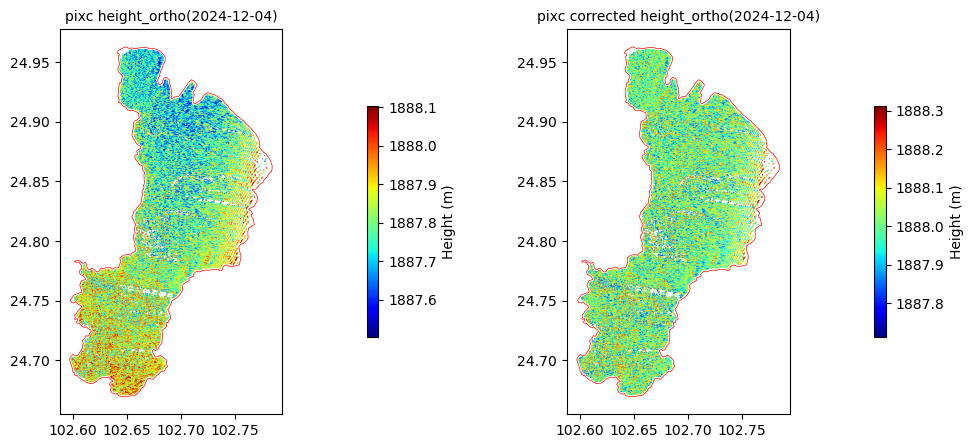

In [ ]:
ht_ortho_mean = np.nanmean(pixc_ht_ds.ht_ortho.values)
ht_ortho_cor_mean = np.nanmean(pixc_ht_ds.ht_ortho_cor.values)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
## ax0
scat = ax[0].scatter(x= pixc_ht_ds.longitude, y=pixc_ht_ds.latitude, 
                      c=pixc_ht_ds.ht_ortho.values,
                      vmin=ht_ortho_mean - 0.3,
                      vmax=ht_ortho_mean + 0.3,
                      s=0.5, edgecolor='none', cmap='jet')
lake_gdf.plot(ax=ax[0], color='none', edgecolor='red', linewidth=0.5)
plt.colorbar(scat, label='Height (m)', shrink=0.6, pad=0.2)  
ax[0].set_title('pixc height_ortho' + f'({pixc_ht_ds.attrs["date"]})', fontsize=10)
## ax1
scat = ax[1].scatter(x=pixc_ht_ds.longitude, y=pixc_ht_ds.latitude, 
                      c=pixc_ht_ds.ht_ortho_cor.values,
                      vmin=ht_ortho_cor_mean - 0.3,
                      vmax=ht_ortho_cor_mean + 0.3,
                      s=0.5, edgecolor='none', cmap='jet')
lake_gdf.plot(ax=ax[1], color='none', edgecolor='red', linewidth=0.5)
plt.colorbar(scat, label='Height (m)', shrink=0.6, pad=0.2)  
ax[1].set_title('pixc corrected height_ortho' + f'({pixc_ht_ds.attrs["date"]})', fontsize=10)


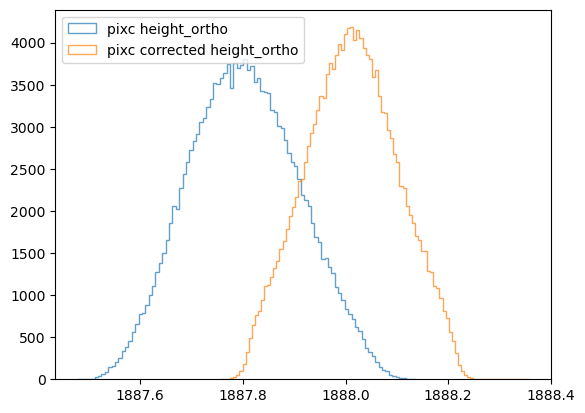

In [ ]:
plt.hist(pixc_ht_ds.ht_ortho.values.ravel(), bins=100, 
                        alpha=0.7, histtype='step', label='pixc height_ortho');
plt.hist(pixc_ht_ds.ht_ortho_cor.values.ravel(), bins=100, 
                        alpha=0.7, histtype='step', label='pixc corrected height_ortho');
plt.legend();
